# Definitions

In [2]:
# Imports for JupyterLite
%pip install -q ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "arial",
    "font.serif": ["Computer Modern Roman"],
    'font.size': 14
})

### Define Constants

In [43]:
h_planck = 4.135667696e-15 # eV s
cs = 29979245800 # cm /s 
rydberg_energy = 13.6056923 # eV
lyAlpha_energy = 10.198810993784 # eV
kB = 8.617343e-5 # eV / K
G = 6.674e-8 # dyne / cm^2 / g^2
pi = 3.14159265
e = 2.718281828
sigma_th = 6.65245873e-25 # Thomson cross section in cm^2
rec = 2.81794003e-13 # classical electron radius

### Define masses

mp = 1.67262171e-24 # grams
mp_eV = 938.272029e+6 # eV

me = 9.1093827e-28 # grams
me_eV = 5.10998918e+5 # eV

### Define conversion factors

In [40]:
pc_to_cm = 3.0856776e+18 # cm
msol_to_grams = 1.9891e+33 # grams
eV_to_ergs = 1.60217653e-12 # ergs
GeV_To_InvSec = 1.52e+24 # sec

### Define Black Body functions

In [41]:
def n_BB (Tr, en):
    return 8*pi*en**2 / (h_planck * cs)**3 / (np.exp(en/(kB * Tr)) -1 ) # number / eV /cm^3

def u_BB (Tr):
    return 8*pi**5 / (15 * (h_planck*cs)**3) * (kB*Tr)**4 # eV / cm^3

(1, 1000000000.0)

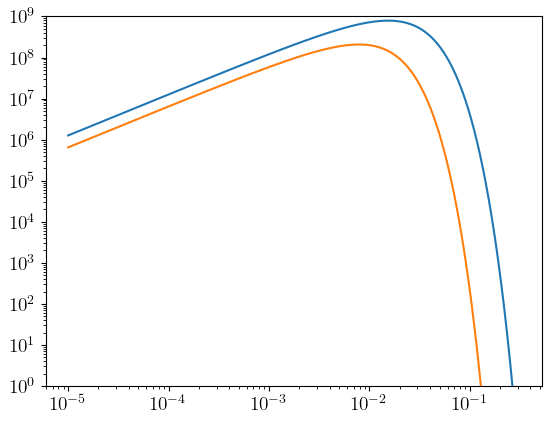

In [42]:
en_list=10**np.arange(-5,-0.5,0.01)

plt.figure()
plt.plot(en_list, n_BB(T_CMB(40), en_list))
plt.plot(en_list, n_BB(T_CMB(20), en_list))
plt.yscale('log')
plt.xscale('log')
plt.ylim(1,1e+9)

### Define Cosmology

In [10]:
# In acccordance to Planck 2018
h=0.674
H0=67.4/(pc_to_cm*10)
Omega_c = 0.12 / h**2
Omega_b = 0.0224 / h**2
Omega_m = Omega_c + Omega_b
Omega_lambda = 1 - Omega_m
Yp = 0.245

# Critical density
RhoCrit = 3*H0**2/(8*pi*G) * cs**2/eV_to_ergs # eV cm^-3

# Define Critical overdensity
Delta_c =200

# Define Hydrogen number density
nH0 = RhoCrit*Omega_b*(1 - Yp)/mp_eV

# Define Helium number density
nHe0 = RhoCrit*Omega_b*(Yp)/mp_eV

# Define total atom density
nA0 = nH0 + nHe0


In [11]:
## Define Hubble function

def Hubble(z):
    return H0*(Omega_lambda + Omega_m*(1+z)**3)**(1/2)

In [12]:
# Define IGM, CMB, and virial temperatures

def T_IGM(z):
    return 1/40 * (1+z)**2

def T_CMB(z):
    return 2.725*(1+z)

def Tvir(z, mhalo):

    fac = (
            1.98e+4 * (1.22/0.6) *
            (Omega_m / Omega_t_m(z) * Delta_c / (18*pi**2) )**(1/3) *
            (mhalo/ 10**8)**(2/3) *
            (1+z)/10 * h**(2/3)
          )
    return fac


In [13]:
mhalo_list = 10**np.arange(1,9)

plt.figure()
plt.plot(mhalo_list, Tvir(20, mhalo_list))

plt.xscale('log')
plt.yscale('log')
plt.grid()

NameError: name 'Omega_t_m' is not defined

<Figure size 640x480 with 0 Axes>

In [14]:
# Define cosmological density parameters at time t

def Omega_t_m(z):
    return Omega_m*(1+z)**3 / (Hubble(z)/H0)**2

def Omega_t_lambda(z):
    return Omega_lambda / (Hubble(z)/H0)**2


# Define growth factor

def growth_fac(z):
    
    # Define the constant denominator
    const = Omega_m*( Omega_m**(4/7) - Omega_lambda + (1 + Omega_m/2)*(1 + Omega_lambda/70) )**(-1)

    func = Omega_t_m(z)*( Omega_t_m(z)**(4/7) - Omega_t_lambda(z) + (1 + Omega_t_m(z)/2)*(1 + Omega_t_lambda(z)/70) )**(-1)

    return (func/const/(1+z))

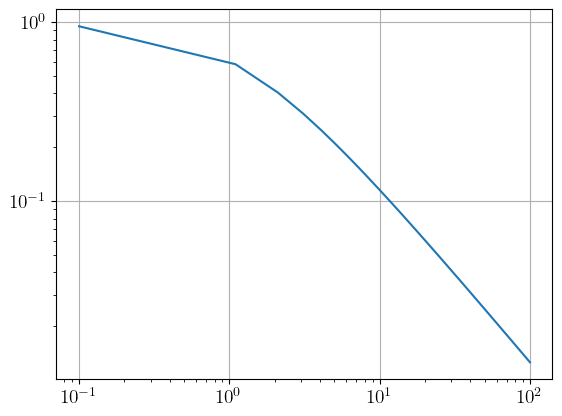

In [15]:
# Plot growth factor
z_list=np.arange(0.1,101)

plt.figure()
plt.plot(z_list, growth_fac(z_list))

plt.xscale('log')
plt.yscale('log')
plt.grid()

### Define Rate Coefficients

In [16]:
# Collisional rate coefficients. units cm^3 / s

# case B Hydrogen Recombination
def case_B(T):
    return 2.54e-13*(T/10**4)**(-0.8163)
    
# Electron attachment to H. Taken from Hirata 2006. Valid for T<=10^(4) K
def C_Hminus(T):
    return 3e-16*(T/300)**0.95 * e**(-T/9320)

# H2 formation via H minus
def C_H2(T):
    return 1.5e-9 * (T/300)**(-0.1)


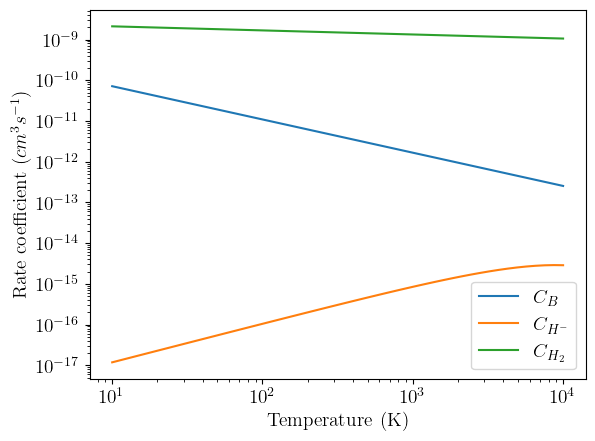

In [17]:
# Plot Rate Coefficients

temp_list = 10**np.linspace(1,4)

plt.plot(temp_list, case_B(temp_list), label=r'$C_B$')
plt.plot(temp_list, C_Hminus(temp_list), label=r'$C_{H^-}$')
plt.plot(temp_list, C_H2(temp_list), label=r'$C_{H_2}$')

plt.loglog()
plt.xlabel(r"Temperature (K)", fontsize=14)
plt.ylabel(r"Rate coefficient ($cm^3 s^{-1}$)", fontsize=14)
plt.legend()
plt.show()

### Cross Sections

In [18]:
def sigma_Hm(en):
    en = np.asanyarray(en)

    result = np.zeros_like(en, dtype=float)

    val = 7.928e+5 * h_planck**1.5
    
    mask = en>=0.755
    result[mask] = val*(en[mask] - 0.755)**1.5 / en[mask]**3
    
    return result

In [19]:
sigma_Hm(np.array([0,0.5,1,2,3,4,5]))

array([0.00000000e+00, 0.00000000e+00, 2.55700290e-17, 3.66139121e-17,
       2.62689582e-17, 1.92585760e-17, 1.47532813e-17])

In [20]:
sigma_Hm(1.21356)

array(3.66346957e-17)